# EEG: Fp1 - MIMO Stacked Convolutional Network
(Left Frontopolar Cloth Surface Electrode on the Forehead)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Analysis-and-Transformation" data-toc-modified-id="Analysis-and-Transformation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis and Transformation</a></span></li><li><span><a href="#Datasets" data-toc-modified-id="Datasets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Datasets</a></span></li><li><span><a href="#Network" data-toc-modified-id="Network-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Network</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Validation" data-toc-modified-id="Validation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Validation</a></span><ul class="toc-item"><li><span><a href="#Distributions-of-Validation-Errors" data-toc-modified-id="Distributions-of-Validation-Errors-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Distributions of Validation Errors</a></span></li><li><span><a href="#Visualization-of-Validation-Predictions" data-toc-modified-id="Visualization-of-Validation-Predictions-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Visualization of Validation Predictions</a></span></li></ul></li><li><span><a href="#Test-Predictions" data-toc-modified-id="Test-Predictions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Test Predictions</a></span></li></ul></div>

## Initialization

In [1]:
# !pip install --use-feature=in-tree-build psutil requests pmdarima nb_black

In [3]:
# !pip install --use-feature=in-tree-build ../timeseries-pytorch/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/timeseries-pytorch

<IPython.core.display.Javascript object>

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%aimport timeseries

<IPython.core.display.Javascript object>

In [2]:
import os
import IPython.display
from pprint import pprint
from datetime import datetime, timedelta
from collections import OrderedDict
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader

import pytorch_fit
from pytorch_fit import fit, evaluate, train_epoch, evaluate
from pytorch_fit.metrics import Metric
from pytorch_fit.stopping import EarlyStopping
from pytorch_fit.visuals import (
    plot_history,
    display_last_history,
    display_network,
    format_vertical_headers,
)

import timeseries as tss
from timeseries import plot_ts
from timeseries.analysis import acf, pacf, plot_hist, plot_acf, plot_pacf, plot_stats
from timeseries.transform import IHSTransformer, get_smoothed
from timeseries.forecast.utils import Results
from timeseries.forecast.utils import (
    plot_model_test_prediction,
    plot_ground_truth,
    plot_hist_model_scores,
)
from timeseries.forecast.scorings import get_comparison_scorings
from timeseries.forecast import average_scores
from timeseries.forecast.hyper_params import (
    make_grid,
    grid_search_hyper_params,
    print_hyper_scores,
    sorted_scores,
)
from timeseries.forecast.models import (
    SarimaModel,
    sarima_model_version,
    sarima_model_version_str,
)

from timeseries_pytorch import set_trainable
from timeseries_pytorch.models import TimeWindowForecastingModel
from timeseries_pytorch.transform import get_exogenous_seasonal_dct_lst
from timeseries_pytorch.datasets import TimeWindowForecastingDataset
from timeseries_pytorch.metrics import OriginalMetric

from timeseries_data import EEGData

# import timeseries as tss
# from timeseries.plotting import plot_ts, plot_hist, plot_acf, plot_pacf
# from timeseries.transform import IHSTransformer, get_smoothed

# from utils.timeseries_data import EEGData
# from utils.results import Results
# from utils.plotting import (
#     plot_model_test_prediction,
#     plot_ground_truth,
#     plot_hist_model_scores,
# )
# from scorings import get_comparison_scorings
# from average_scoring import average_scores
# from hyper_params import make_grid, grid_search_hyper_params
# from models.time_window_model import TimeWindowForecastingModel
# from utils.plotting import (
#     plot_model_test_prediction,
#     plot_ground_truth,
#     plot_hist_model_scores,
# )
# from dnn.exogenous import get_exogenous_seasonal_dct_lst
# from dnn.time_window_forcasting_dataset import TimeWindowForecastingDataset
# from dnn.losses_and_metrics import OriginalMetric
# from dnn.utils import set_trainable

<IPython.core.display.Javascript object>

In [4]:
import nb_black

from notebook_init import notebook_init

notebook_init()

<IPython.core.display.Javascript object>

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<IPython.core.display.Javascript object>

In [6]:
scorings = get_comparison_scorings()

ts_data = EEGData()
data_type = ts_data.data_type
data_name = ts_data.data_name

val_results = Results(data_type, data_name, "val")
test_results = Results(data_type, data_name, "test")

ts = ts_data.ts
train_intv = ts_data.train_interval
val_intv = ts_data.val_interval
test_intv = ts_data.test_interval
pred_steps = ts_data.pred_steps
pred_jump = ts_data.pred_jump

<IPython.core.display.Javascript object>

## Analysis and Transformation

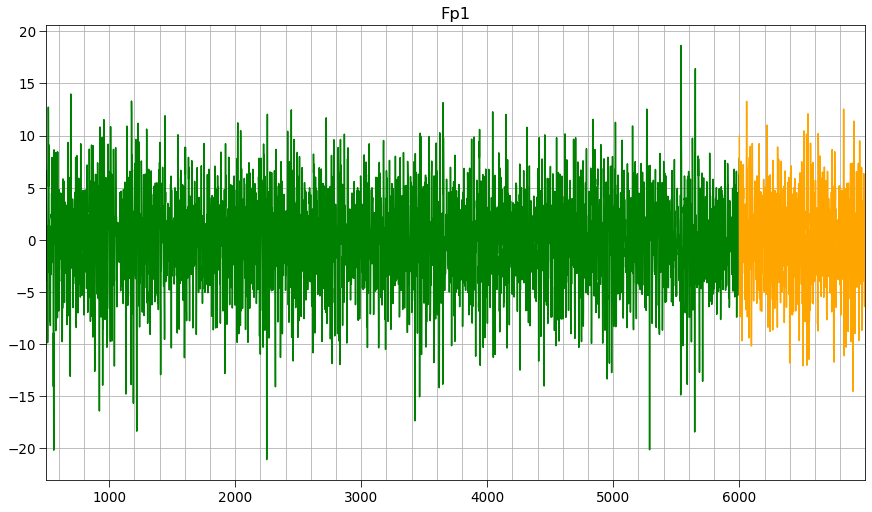

<IPython.core.display.Javascript object>

In [7]:
fig = plot_ts(train_intv.view(), color="green")
display(plot_ts(val_intv.view(), fig=fig, color="orange"))

Order of differencing: 0
MLE of IHS lambda: 8.725000e-02


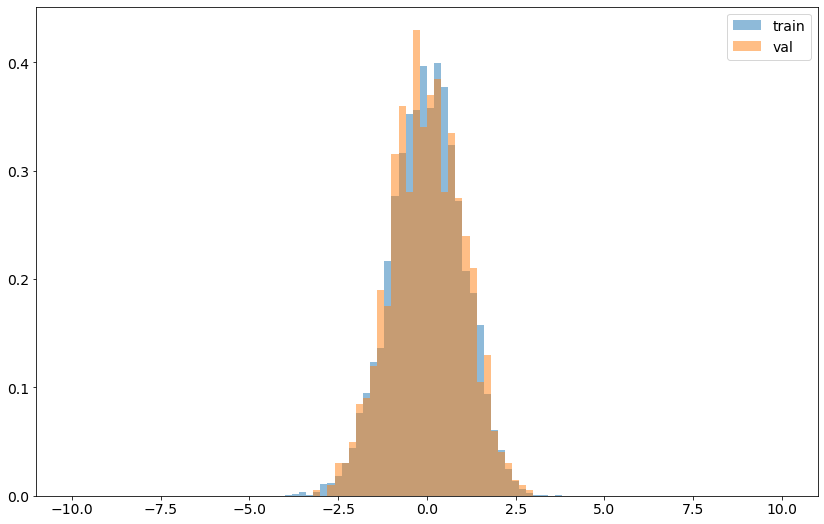

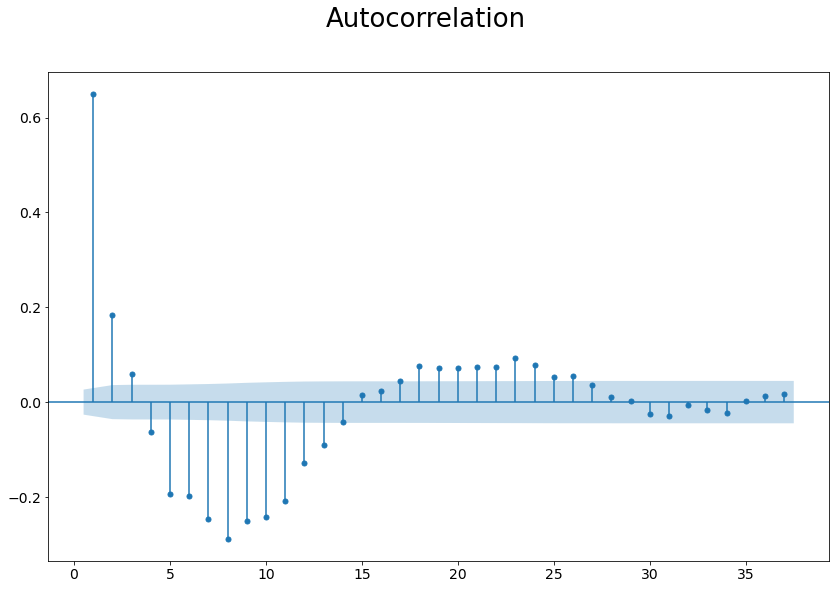

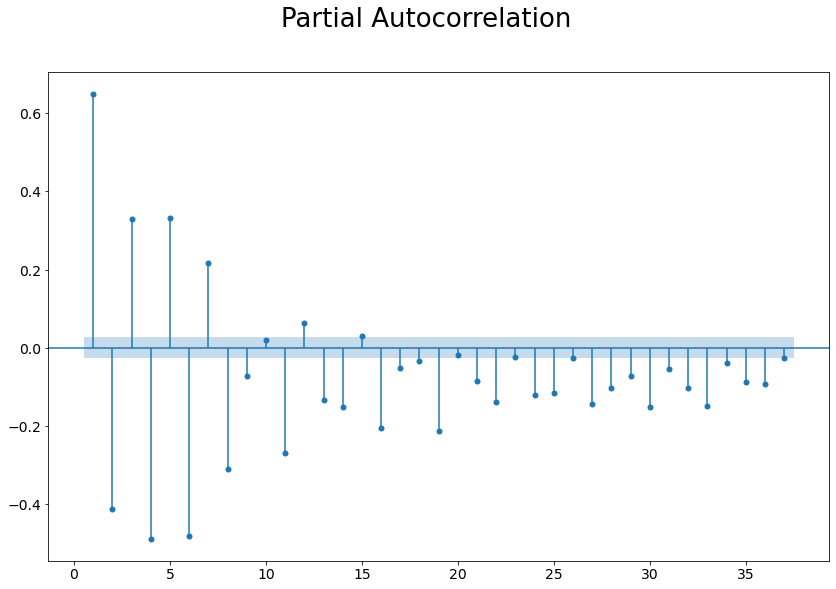

<IPython.core.display.Javascript object>

In [8]:
trans = IHSTransformer(train_intv.view(ts), verbose=True)
original_trans_ts = trans_ts = trans.transform(ts)

fig = plot_hist(
    train_intv.view(trans_ts), bins=100, range=(-10, 10), density=True, name="train"
)
display(
    plot_hist(
        val_intv.view(trans_ts),
        bins=100,
        range=(-10, 10),
        density=True,
        name="val",
        fig=fig,
        title="Distribution",
    )
)

alpha = 0.05
display(plot_acf(train_intv.view(trans_ts), alpha=alpha, zero=False))
display(plot_pacf(train_intv.view(trans_ts), alpha=alpha, zero=False))

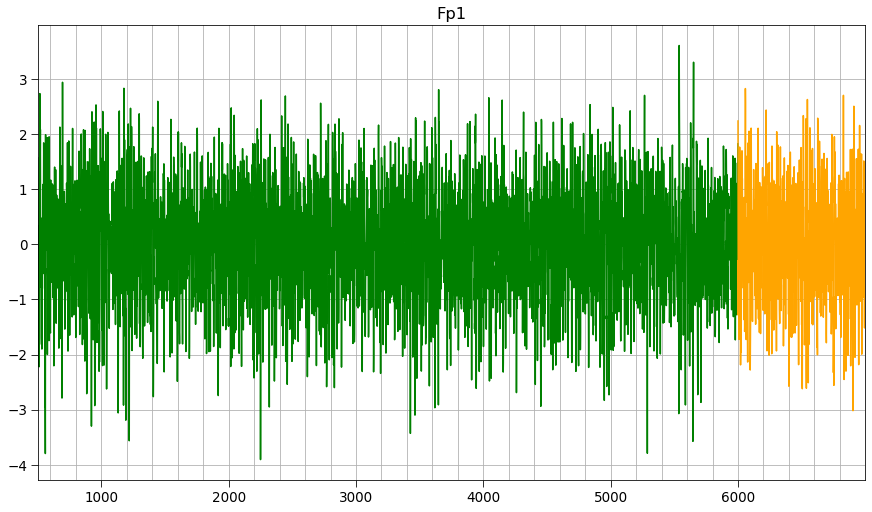

<IPython.core.display.Javascript object>

In [9]:
fig = plot_ts(train_intv.view(trans_ts), color="green")
display(plot_ts(val_intv.view(trans_ts), fig=fig, color="orange"))

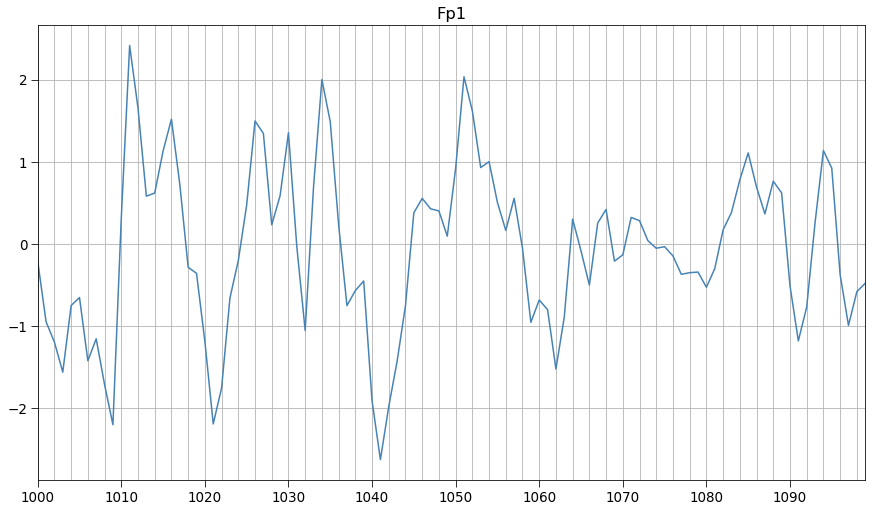

<IPython.core.display.Javascript object>

In [10]:
intv = tss.Interval(ts, 1000, 1100)
fig = plot_ts(intv.view(trans_ts))
display(fig)

## Datasets

In [11]:
max_window_len = 500
short_val_intv = tss.Interval(ts, val_intv.begin, val_intv.begin + 500)

tw_train_dataset = TimeWindowForecastingDataset(
    trans_ts,
    train_intv,
    max_window_len=max_window_len,
    pred_steps=pred_steps,
    original_ts=ts,
    original_prevs_len=trans.d,
)
tw_val_dataset = TimeWindowForecastingDataset(
    trans_ts,
    val_intv,
    max_window_len=max_window_len,
    pred_steps=pred_steps,
    original_ts=ts,
    original_prevs_len=trans.d,
)

<IPython.core.display.Javascript object>

## Network

In [30]:
window_len = 60


def BaseConv():
    return nn.Sequential(
        OrderedDict(
            [
                (
                    "conv1_1",
                    nn.Conv1d(1, 16, 3, padding=1, stride=1, bias=False),
                ),  ## x: 60 -> 60
                ("bn1_1", nn.BatchNorm1d(16)),
                ("sigm1_1", nn.Sigmoid()),
                (
                    "conv1_2",
                    nn.Conv1d(16, 16, 3, padding=1, stride=1, bias=False),
                ),  ## x: 60 -> 60
                ("bn1_2", nn.BatchNorm1d(16)),
                ("sigm1_1", nn.Sigmoid()),
                ("maxp1", nn.MaxPool1d(2, padding=0, stride=2)),  # x: 60 -> 30
                (
                    "conv2_1",
                    nn.Conv1d(16, 16, 3, padding=1, stride=1, bias=False),
                ),  # x: 30 -> 30
                ("bn2_1", nn.BatchNorm1d(16)),
                ("sigm2_1", nn.Sigmoid()),
                ("dropout2_1", nn.Dropout()),
                (
                    "conv2_2",
                    nn.Conv1d(16, 32, 3, padding=1, stride=1, bias=False),
                ),  # x: 30 -> 30
                ("bn2_2", nn.BatchNorm1d(32)),
                ("sigm2_2", nn.Sigmoid()),
                ("maxp2", nn.MaxPool1d(2, padding=0, stride=2)),  # x: 30 -> 15
                ("dropout2", nn.Dropout()),
                (
                    "conv3_1",
                    nn.Conv1d(32, 64, 3, padding=1, stride=1, bias=False),
                ),  # x: 15 -> 15
                ("bn3_1", nn.BatchNorm1d(64)),
                ("sigm3_1", nn.Sigmoid()),
                ("dropout3_1", nn.Dropout()),
                (
                    "conv3_2",
                    nn.Conv1d(64, 128, 3, padding=1, stride=1, bias=False),
                ),  # x: 15 -> 15
                ("bn3_2", nn.BatchNorm1d(128)),
                ("sigm3_2", nn.Sigmoid()),
                ("maxp3", nn.MaxPool1d(2, padding=0, stride=2)),  # x: 15 -> 7
                ("flatten", nn.Flatten()),  # 7 * 128
                ("dropout_fc0", nn.Dropout()),
            ]
        )
    )


class ConvCNNForecaster(nn.Module):
    def __init__(self, base_net, pred_steps):
        super().__init__()
        self.base_net = base_net
        self.pred_steps = pred_steps
        self.head_net = nn.Sequential(
            OrderedDict(
                [
                    ("fc1", nn.Linear(7 * 128, 64, bias=False)),
                    ("bn1", nn.BatchNorm1d(64)),
                    ("sigm1", nn.Sigmoid()),
                    ("dropout_fc1", nn.Dropout()),
                    ("fc2", nn.Linear(64, pred_steps, bias=True)),
                ]
            )
        )

    def forward(self, x, ex=None):
        x = self.base_net(x)
        x = self.head_net(x)
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        return x

<IPython.core.display.Javascript object>

## Training

In [28]:
val_results.scores_table()

,Scoring,RMSE,MAE,MASE,sMAPE
Model,Version,,,,
Median of Medians,"(5,29)[2]",4.203262,3.409748,1.144932,179.661082
ARIMA,"(51,0,0)",3.659725,2.809725,0.940641,116.341639


<IPython.core.display.Javascript object>

In [15]:
models = [
    ("Median of Medians", "(5,29)[2]"),
    ("ARIMA", "(51,0,0)"),
]
val_preds = {}
val_scores = {}
for model, version in models:
    val_results.set_model(model, version)
    val_results.load_model_scores()
    val_scores[(model, version)] = val_results.get_model_scores()
    val_results.add_model_scores(val_scores[(model, version)])

<IPython.core.display.Javascript object>

In [16]:
val_results.scores_table()

,Model,Version,RMSE,MAE,MASE,sMAPE
0,Median of Medians,"(5,29)[2]",4.203262,3.409748,1.144932,179.661082
1,ARIMA,"(51,0,0)",3.659725,2.809725,0.940641,116.341639


<IPython.core.display.Javascript object>

In [32]:
base_conv_net = BaseConv()

huber_loss = torch.nn.HuberLoss(reduction="sum", delta=0.2)
original_mae = OriginalMetric(trans, "MAE")

val_loss_stopping = EarlyStopping(
    "Loss", "val_loss", n_epochs=40, stats_fun=np.max, min_change=-0.00001
)
val_mae_stopping = EarlyStopping(
    "MAE", "val_mae", n_epochs=50, stats_fun=np.mean, min_change=-0.1
)
val_stopping = val_loss_stopping.and_(val_mae_stopping)

head_history_lst = []
whole_history_lst = []
head_initial_epoch = 1
whole_initial_epoch = 1
for steps in list(range(1, pred_steps)) + [pred_steps]:
    print(f"\npred_steps: {steps}")
    tw_train_dataset.set(window_len=window_len, pred_steps=steps)
    tw_val_dataset.set(window_len=window_len, pred_steps=steps)

    tw_train_loader = DataLoader(tw_train_dataset, batch_size=100, shuffle=False)
    tw_val_loader = DataLoader(tw_val_dataset, batch_size=200)

    forecaster = ConvCNNForecaster(base_conv_net, steps).to(device)
    set_trainable(base_conv_net, steps == 1)
    history = {}
    head_history_lst.append(history)
    fit(
        forecaster,
        device,
        "Adam",
        huber_loss,
        tw_train_loader,
        tw_val_loader,
        metrics=[original_mae],
        metrics_val_only=True,
        lr=1e-2,
        n_epochs=10000,
        initial_epoch=head_initial_epoch,
        stop_cond=val_stopping,
        history=history,
    )
    head_initial_epoch += len(history["Loss"]["train_loss"])

    if steps > 1:
        set_trainable(base_conv_net)
        history = {}
        whole_history_lst.append(history)
        fit(
            forecaster,
            device,
            "Adam",
            huber_loss,
            tw_train_loader,
            tw_val_loader,
            metrics=[original_mae],
            metrics_val_only=True,
            lr=1e-2,
            n_epochs=10000,
            initial_epoch=whole_initial_epoch,
            stop_cond=val_stopping,
            history=history,
        )
        whole_initial_epoch += len(history["Loss"]["train_loss"])


pred_steps: 30
Epoch    1:   train_loss: 6.359, val_loss: 4.935, val_mae: 3.403, elapsed time: 2.8s lapsed time: 2.8s 
Epoch    2:   train_loss: 6.233, val_loss: 4.934, val_mae: 3.403, elapsed time: 2.4s lapsed time: 2.4s 
Epoch    3:   train_loss: 6.154, val_loss: 4.934, val_mae: 3.402, elapsed time: 2.5s lapsed time: 2.5s 
Epoch    4:   train_loss: 6.110, val_loss: 4.933, val_mae: 3.402, elapsed time: 2.4s lapsed time: 2.4s 
Epoch    5:   train_loss: 6.076, val_loss: 4.933, val_mae: 3.402, elapsed time: 2.3s lapsed time: 2.3s 
Epoch    6:   train_loss: 6.059, val_loss: 4.934, val_mae: 3.402, elapsed time: 2.3s lapsed time: 2.3s 
Epoch    7:   train_loss: 6.040, val_loss: 4.934, val_mae: 3.402, elapsed time: 3.8s lapsed time: 3.8s 
Epoch    8:   train_loss: 6.037, val_loss: 4.933, val_mae: 3.402, elapsed time: 3.8s lapsed time: 3.8s 
Epoch    9:   train_loss: 6.031, val_loss: 4.933, val_mae: 3.402, elapsed time: 3.5s lapsed time: 3.5s 
Epoch   10:   train_loss: 6.028, val_loss: 4.933

<IPython.core.display.Javascript object>

In [18]:
torch.__version__

'1.9.0+cu102'

<IPython.core.display.Javascript object>

## Validation

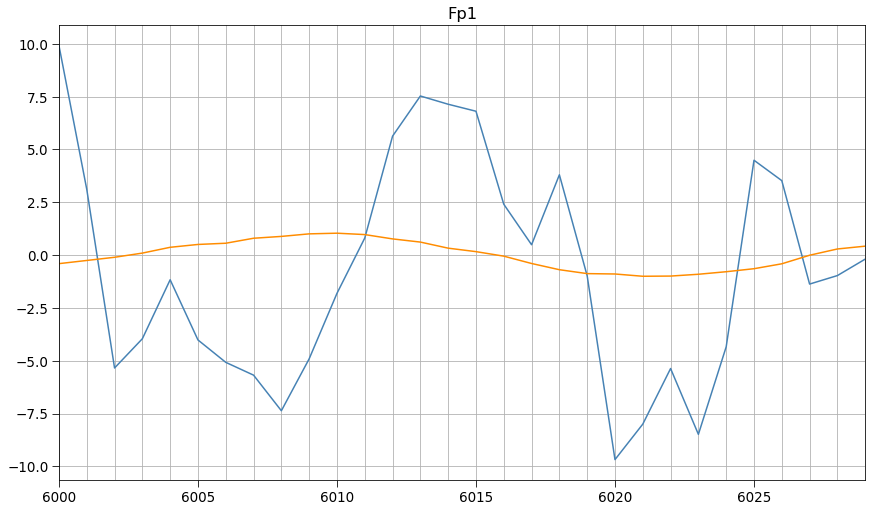

<IPython.core.display.Javascript object>

In [33]:
intv = tss.Interval(trans_ts, val_intv.begin, val_intv.begin + 30)
model = TimeWindowForecastingModel(
    forecaster,
    window_len,
    device,
    detrans=trans,
)
pred = model.predict(trans_ts, intv, original_ts=ts)
fig = plot_ts(intv.view(ts))
plot_ts(pred, color="darkorange", fig=fig)

In [ ]:
%%time
conv_forecaster.eval()
model = TimeWindowForecastingModel(conv_forecaster, window_len, device)
model.fit(trans_ts, train_intv)
val_mean_scores, val_all_scores, val_preds = average_scores(
    model,
    trans_ts,
    val_intv,
    scorings=["MAE"],
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
model_name = "Stacked Convs"
model_version = "plain"
pprint(val_mean_scores)

### Distributions of Validation Errors

In [ ]:
scoring_name = "MAE"
fig = plot_hist_model_scores(
    val_all_scores,
    scoring_name,
    data_name=data_name,
    model_name=model_name,
    model_version=model_version,
    in_label=True,
    engine="plotly",
)
display(fig)

### Visualization of Validation Predictions

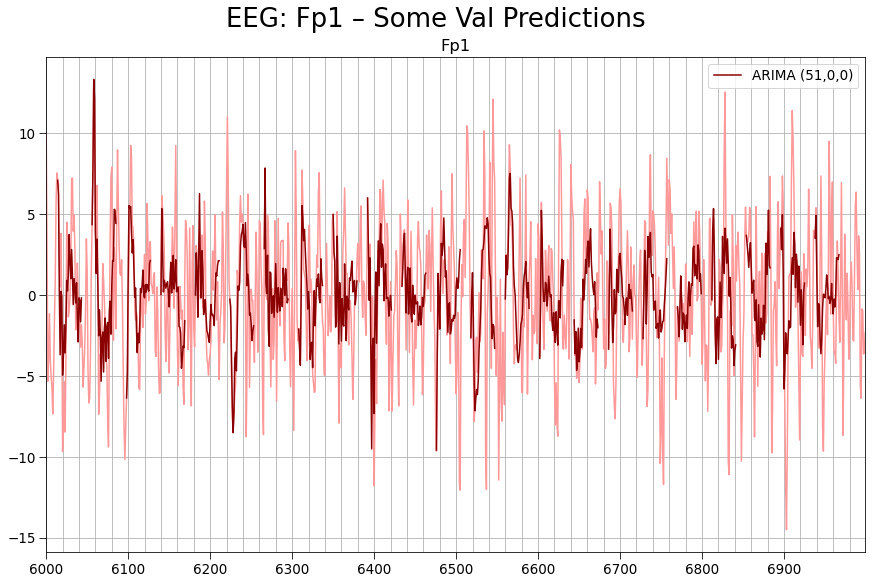

<IPython.core.display.Javascript object>

In [37]:
fig_time_delta = 10
fig = plot_ground_truth(val_intv, mode="val", data_type=data_type, data_name=data_name)
display(
    plot_model_test_prediction(
        val_intv,
        fig_time_delta,
        val_preds,
        model_name=model_name,
        model_version=model_version,
        fig=fig,
    )
)

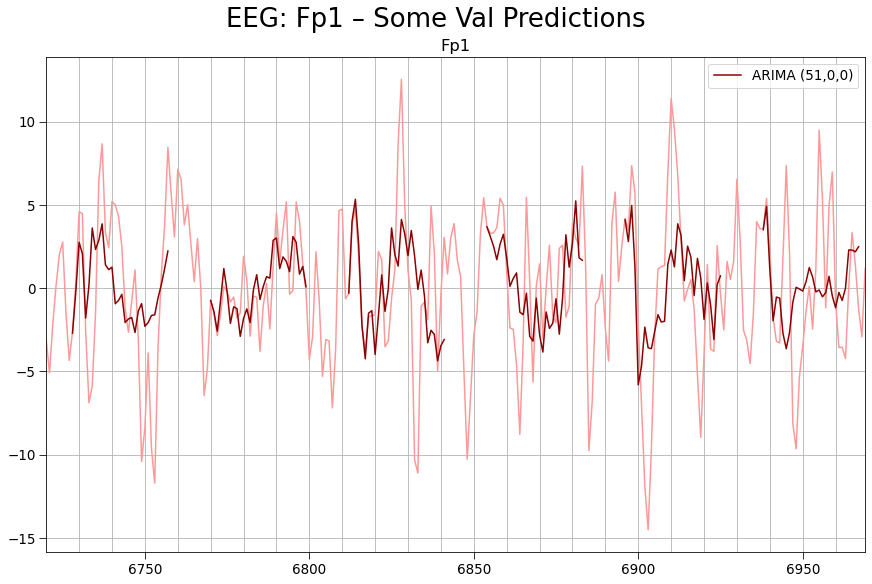

<IPython.core.display.Javascript object>

In [36]:
short_val_intv = tss.Interval(ts, 6720, 6970)
fig_time_delta = 7
fig = plot_ground_truth(
    short_val_intv, mode="val", data_type=data_type, data_name=data_name
)
display(
    plot_model_test_prediction(
        short_val_intv,
        fig_time_delta,
        val_preds,
        model_name=model_name,
        model_version=model_version,
        fig=fig,
    )
)

## Test Predictions

In [38]:
%%time
model.update(trans_ts, val_intv)
test_mean_scores, test_all_scores, test_preds = average_scores(
    model,
    trans_ts,
    test_intv,
    trans=trans,
    original_ts=ts,
    scorings=scorings,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(test_mean_scores)
test_results.set_model(model_name, model_version)
test_results.add_model_scores(test_all_scores, test_mean_scores)
test_results.add_model_preds(test_preds)

148/148 – RMSE: 3.53412, MAE: 2.71143, MASE: 0.90923, sMAPE: 119.77098, elapsed time: 3h 32min 47s (last: 51.2s)         
{'MAE': 2.7114261653495233,
 'MASE': 0.9092321425466278,
 'RMSE': 3.5341195756288557,
 'sMAPE': 119.77097721479873}
CPU times: user 5h 36min 58s, sys: 3h 21min 30s, total: 8h 58min 28s
Wall time: 3h 34min 50s


<IPython.core.display.Javascript object>